In [ ]:
!pip install deepface

In [2]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [4]:
import cv2
import matplotlib.pyplot as plt

def image_visuals(img):
    questions = ["what and where is the adult looking at in the image", "what and where is the child looking at", "what is the child doing in the image", "what is the adult doing in the image"]
    texts = ["Adult loking at: ","Child looking at: "]
    ans = []
    y_offset = 50  # Initial y-coordinate for the first question
    for i,question in enumerate(questions):
        prompt = f"Question: {question} Answer:"
        inputs = processor(img, text=prompt, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=10)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        ans.append(generated_text)
    ans[1] = ans[1][27:]
    for i in range(2):
        cv2.putText(img,texts[i]+": "+ans[i], (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
        y_offset += 50  # Increment the y-coordinate for the next question
    return img,ans

In [5]:
from deepface import DeepFace as df
import cv2
import time
t1 = time.time()
video_path = "...path/to/your/video.mp4"
cap = cv2.VideoCapture(video_path)
fps = 1
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/output.mp4', fourcc, fps, (width, height))

analysis = {'child':{'frame':[],'query':[],'emotion':[]},'adult':{'frame':[],'query':[],'emotion':[]}}
processed_frame = 0
frame_cnt = 1
emotion_person = {"child":{"happy":0,"neutral":0,"surprise":0},"adult":{"happy":0,"neutral":0,"surprise":0}}
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        if frame_cnt%30 == 0:
            processed_frame+=1
            faces = df.analyze(frame, actions=['emotion','age'],enforce_detection=False,detector_backend='retinaface')
            ages = [face_info['age'] for face_info in faces]
            if not ages:
              continue
            youngest_person_idx = ages.index(min(ages))
            if faces[0]['face_confidence']==1.0:
              frame,ans = image_visuals(frame)

            for i,face in enumerate(faces):
                if face['face_confidence']==1.0:
                    if len(faces)>1:
                        if i==youngest_person_idx:
                            person = "child"
                        else:
                            person = "adult"
                    else:
                        if ages[0]<25:
                            person = "child"
                        else:
                            person = "adult"

                    x,y,w,h = face['region']['x'], face['region']['y'], face['region']['w'], face['region']['h']
                    if face['emotion']['happy']>face['emotion']['neutral'] and face['emotion']['happy']>face['emotion']['surprise']:
                        emotion = "happy"
                    elif face['emotion']['neutral']>face['emotion']['happy'] and face['emotion']['neutral']>face['emotion']['surprise']:
                        emotion = "neutral"
                    else:
                        emotion = "surprise"

                    emotion_person[person][emotion] += 1
                    analysis[person]['frame'].append(processed_frame)
                    analysis[person]['emotion'].append(emotion)

                    if person == 'adult':
                      analysis['adult']['query'].append([ans[0],ans[3]])
                    else:
                      analysis['child']['query'].append([ans[1],ans[2]])

                    cv2.putText(frame, f"{person}: {emotion}", (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
                    cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)
            out.write(frame)
        frame_cnt += 1
    else:
        break
print("Video processing complete.")
print("Time taken: ", time.time()-t1)
print("time per frame: ", (time.time()-t1)/(frame_cnt//30))
print("Output saved as output.mp4")
print("Child emotions: ", emotion_person["child"])
print("Adult emotions: ", emotion_person["adult"])
out.release()
cap.release()
cv2.destroyAllWindows()

24-04-06 18:01:13 - Directory /root/.deepface created
24-04-06 18:01:13 - Directory /root/.deepface/weights created
24-04-06 18:01:16 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 270MB/s]
Action: emotion:   0%|          | 0/2 [00:00<?, ?it/s]

24-04-06 18:01:27 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5

100%|██████████| 5.98M/5.98M [00:00<00:00, 92.8MB/s]
Action: age:  50%|█████     | 1/2 [00:02<00:02,  2.57s/it]    

24-04-06 18:01:30 - age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  4%|▍         | 23.1M/539M [00:00<00:02, 230MB/s]
 12%|█▏        | 64.5M/539M [00:00<00:01, 336MB/s]
 18%|█▊        | 98.6M/539M [00:00<00:01, 313MB/s]
 24%|██▍       | 131M/539M [00:00<00:01, 304MB/s] 
 30%|██▉       | 161M/539M [00:00<00:01, 289MB/s]
 35%|███▌      | 191M/539M [00:00<00:01, 284MB/s]
 42%|████▏     | 226M/539M [00:00<00:01, 303MB/s]
 48%|████▊     | 258M/539M [00:00<00:00, 303MB/s]
 54%|█████▎    | 289M/539M [00:01<00:00, 273MB/s]
 59%|█████▉    | 317M/539M [00:01<00:00, 274MB/s]
 64%|██████▍   | 346M/539M [00:01<00:00, 266MB/s]
 69%|██████▉   | 373M/539M [00:01<00:00, 248MB/s]
 74%|███████▍  | 398M/539M [00:01<00:00, 243MB/s]
 79%|███████▊  | 424M/539M [00:01<00:00, 247MB/s]
 83%|████████▎ | 449M/539M [00:01<00:00, 246MB/s]
 88%|████████▊ | 475M/539M [00:01<00:00, 248

Video processing complete.
Time taken:  324.180456161499
time per frame:  1.906951958992902
Output saved as output.mp4
Child emotions:  {'happy': 34, 'neutral': 96, 'surprise': 4}
Adult emotions:  {'happy': 40, 'neutral': 88, 'surprise': 1}


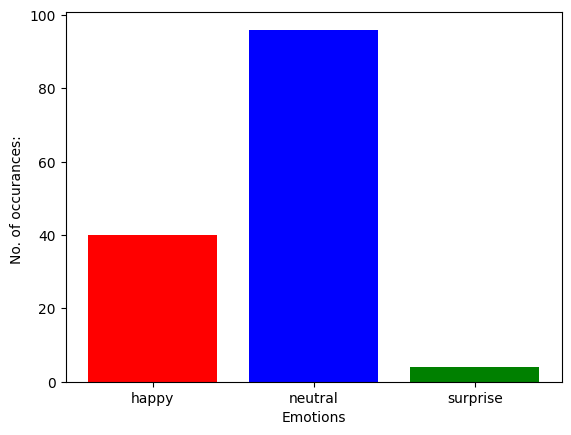

In [6]:
import matplotlib.pyplot as plt
for i in ['adult','child']:
  colors = ['red', 'blue', 'green']
  labels = emotion_person[i].keys()
  values = emotion_person[i].values()
  plt.bar(labels,values,color=colors)
  plt.xlabel("Emotions")
  plt.ylabel("No. of occurances: ")
  plt.savefig(f'{i} emotion.png')

In [7]:
print(len(analysis['child']['frame']),len(analysis['child']['emotion']),len(analysis['child']['query']))

134 134 134


In [8]:
print(len(analysis['adult']['frame']),len(analysis['adult']['emotion']),len(analysis['adult']['query']))

129 129 129


In [9]:
import json


with open('child_data.json', 'w') as f:
    child_data = {
        'frame': analysis['child']['frame'],
        'query': analysis['child']['query'],
        'emotion': analysis['child']['emotion']
    }
    json.dump(child_data, f, indent=4)

# Create the adult data file
with open('adult_data.json', 'w') as f:
    adult_data = {
        'frame': analysis['adult']['frame'],
        'query': analysis['adult']['query'],
        'emotion': analysis['adult']['emotion']
    }
    json.dump(adult_data, f, indent=4)